# LAB3

In this lab we are tasked with exploring various local-search algorithm to solve a black-box problem in the minimum number of fitness calls.

In [1]:
from random import choices, sample, random, randint, choice
from itertools import cycle
from math import exp
import matplotlib.pyplot as plt

import lab9_lib

In [2]:
NUM_LOCI = 1000

class Individual:
    def __init__(self, genome):
        self.genome = genome
        self.fitness = None

    def evaluate(self, fitness):
        if self.fitness is None:
            self.fitness = fitness(self.genome)
        return self.fitness

### Evolutionary Strategy
Let's start with an Evolutionary Strategy, to avoid wasting calls we use an implementation of the $\mu + \lambda$ selection method, we also impose the coexistence of crossover and mutation (we defined them as mutually exclusive in the previous lab).
We expect poor results overall given the randomic nature of the algorithm. 

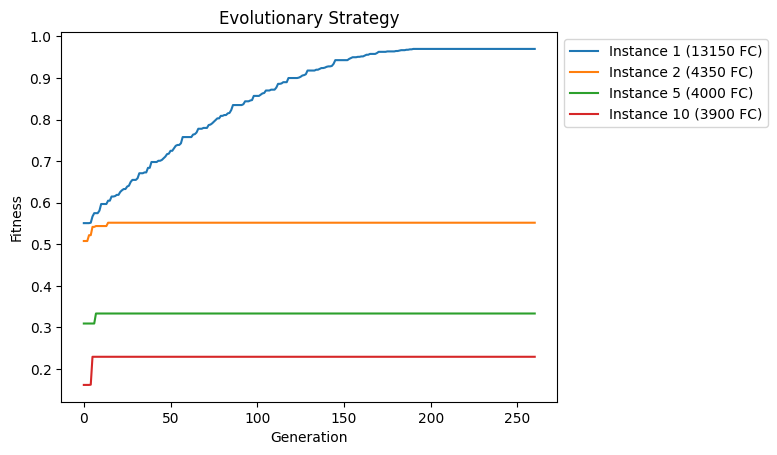

In [3]:
p_1 = lab9_lib.make_problem(1)
p_2 = lab9_lib.make_problem(2)
p_5 = lab9_lib.make_problem(5)
p_10 = lab9_lib.make_problem(10)
            


def crossover(p1:Individual, p2:Individual):
    o = []
    for i in range(NUM_LOCI):
        o.append(choice([p1.genome[i], p2.genome[i]]))
    return Individual(o)

def mutate(m:Individual, min_mutation=0.01, max_mutation=0.02):  #randomly mutates between 1% and 2% of the genome
    o=m.genome.copy()
    n_mutants = randint(int(NUM_LOCI*min_mutation), int(NUM_LOCI*max_mutation))
    mutants = sample(range(NUM_LOCI), n_mutants)
    for i in mutants:
        o[i] = 1 - o[i]
    return Individual(o)

def sortKey(arg, holder, fitness, iteration):  #stores the maximum inside the holder while evaluating fitness
    f = arg.evaluate(fitness)
    if f > holder[0]:
        holder[0]=f
        holder[1]=iteration
    return f

def es(fitness, pop_size=100, num_offsprings=50, mutation_rate=0.15, max_wait=70):
    population = []
    fitness_plot = []
    for _ in range(pop_size):
        c = choices([0, 1], k=NUM_LOCI)
        population.append(Individual(c))
    fitness_holder = [0, 0] #use list as a mutable variable containing the max fitness in position 0 and the index of the last iteration that improved it on position 1
    i = 0
    while fitness_holder[0]!=1 and i < fitness_holder[1] + max_wait:  #if no improvement in max_wait generations, stop
        i += 1
        offsprings = []
        for _ in range(num_offsprings):
            p1, p2 = sample(population, 2)
            o = crossover(p1, p2)
            if random() < mutation_rate:
                o = mutate(o)
            offsprings.append(o)
        population.extend(offsprings)
        population.sort(key = lambda p : sortKey(p, fitness_holder, fitness, i), reverse=True)
        population = population[:pop_size]
        fitness_plot.append(fitness_holder[0])
    return fitness_plot, fitness.calls

es1, es1c = es(p_1)
es2, es2c = es(p_2)
es5, es5c = es(p_5)
es10, es10c = es(p_10)
x_axis = range(max(len(es1), len(es2), len(es5), len(es10)))
for a in [es1, es2, es5, es10]:
    while len(a) < len(x_axis):
        a.append(a[-1])

plt.title("Evolutionary Strategy")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.plot(x_axis, es1, label = "Instance 1 ("+str(es1c)+" FC)")
plt.plot(x_axis, es2, label = "Instance 2 ("+str(es2c)+" FC)")
plt.plot(x_axis, es5, label = "Instance 5 ("+str(es5c)+" FC)")
plt.plot(x_axis, es10, label = "Instance 10 ("+str(es10c)+" FC)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

For the problem of Instance 1 the algorithm seems to be able to find a very good fitness, albeit in a disproportionate number of calls compared to the same algorithm in harder instances. Looking at the graphs seems that for Instance 2 and beyond the algorithm very quickly fossilizes on a suboptimal solution, unable to improve on the local maxima, this is likely due to the fact that, as the generations progress, the diversity of the population plummets and so potentially good genes are never considered.

### Evolutionary Strategy (Island version)
To deal with the problem of limited diversity we implement a Evolutionary Algorithm based on the Islands implementation.
We run three evolutionary algorithms (islands) in parallel each trying to optimize the fitness function. Every so often we migrate some indiduals from one island to another.
We also redefine the crossover by selecting 3 parents instead of two and choosing, for each gene, the value that appears more often between the 3 individuals.

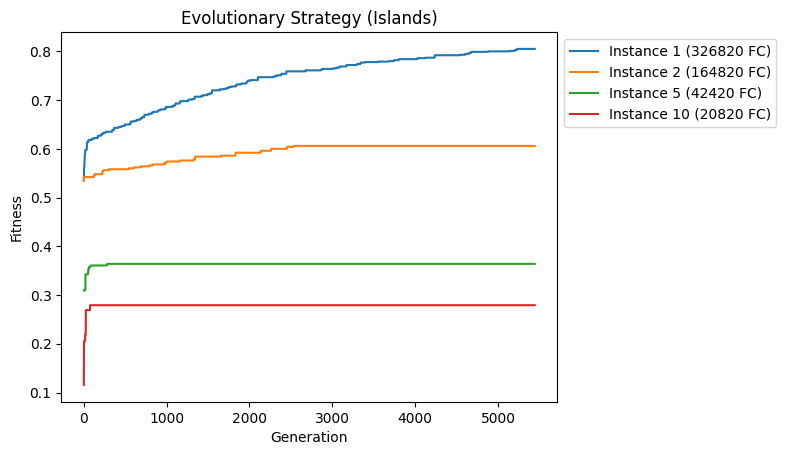

In [4]:
p_1 = lab9_lib.make_problem(1)
p_2 = lab9_lib.make_problem(2)
p_5 = lab9_lib.make_problem(5)
p_10 = lab9_lib.make_problem(10)


def xover3(p1:Individual, p2:Individual, p3:Individual) ->Individual:
    o = []
    for i in range(NUM_LOCI):
        if p1.genome[i] + p2.genome[i] + p3.genome[i] >= 2:
            o.append(1)
        else:
            o.append(0)
    return Individual(o)

def rotate(myList, rotations=1):
    for _ in range(rotations):
        myList.append(myList.pop(0))

def migrate(pops, ratio=0.2):
    migrants = []
    for p in pops:
        indexes = sample(range(len(p)), int(len(p)*ratio))
        indexes.sort(reverse=True)
        selection = []
        for i in indexes:
            selection.append(p[i])
        for i in indexes:
            del p[i]
        migrants.append(selection)

    rotate(migrants)
    for i in range(len(pops)):
        pops[i].extend(migrants[i])


    



def sortIsland(arg, island, holder, fitness, improvement, macro):
    f = arg.evaluate(fitness)
    if f>holder[island]:
        holder[island] = f
        improvement[0] = macro
        #print("Improvement found on macrogeneration:", macro)
    return f

def es_islands(fitness, num_islands=3, pop_size=40, num_offsprings=20, mutation_rate=0.15, max_wait=10, migration_lapse=15):
    islands = []
    fitnesses = []
    fitnesses_plot = []
    last_improvement = [0]
    for island in range(num_islands):
        pop = []
        for _ in range(pop_size):
            c = choices([0, 1], k=NUM_LOCI)
            pop.append(Individual(c))
        islands.append(pop)
        fitnesses.append(0)
        fitnesses_plot.append([])
    macrogeneration = 0
    while max(fitnesses)!=1 and macrogeneration < max_wait + last_improvement[0]:
        macrogeneration += 1
        for island in range(num_islands):
            gen = 0
            while max(fitnesses)!=1 and gen<migration_lapse:
                gen+=1
                offsprings = []
                for _ in range(num_offsprings):
                    p1, p2, p3 = sample(islands[island], 3)
                    o = xover3(p1, p2, p3)
                    if random() < mutation_rate:
                        o = mutate(o)
                    offsprings.append(o)
                islands[island].extend(offsprings)
                islands[island].sort(key = lambda s : sortIsland(s, island, fitnesses, fitness, last_improvement, macrogeneration), reverse=True)
                islands[island] = islands[island][:pop_size]
                fitnesses_plot[island].append(fitnesses[island])
        migrate(islands)
    return fitnesses_plot, fitness.calls

def condense(myList):
    condensated = []
    length = len(myList[0])
    for l in range(length):
        max = 0
        for m in myList:
            if m[l] > max:
                max = m[l]
        condensated.append(max)
    return condensated

temp, esi1c = es_islands(p_1)
esi1 = condense(temp)
temp, esi2c = es_islands(p_2)
esi2 = condense(temp)
temp, esi5c = es_islands(p_5)
esi5 = condense(temp)
temp, esi10c = es_islands(p_10)
esi10 = condense(temp)

x_axis = range(max(len(esi1), len(esi2), len(esi5), len(esi10)))
for a in [esi1, esi2, esi5, esi10]:
    while len(a) < len(x_axis):
        a.append(a[-1])

plt.title("Evolutionary Strategy (Islands)")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.plot(x_axis, esi1, label = "Instance 1 ("+str(esi1c)+" FC)")
plt.plot(x_axis, esi2, label = "Instance 2 ("+str(esi2c)+" FC)")
plt.plot(x_axis, esi5, label = "Instance 5 ("+str(esi5c)+" FC)")
plt.plot(x_axis, esi10, label = "Instance 10 ("+str(esi10c)+" FC)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


    


This approach requires a much larger number of fitness calls compared to the first one, however it seems able to reach better solutions for the harder instances of the problem.

### First Choice Hill Climbing
Let's now consider an Hill Climbing algorithm, given the size of our solution space we employ a "first-choice" algorithm, in which for each step we generate a random neighbor until one with a better fitness is found.
We expect this to be a good implementation of the Hill Climbing algorithm since it's supposed to work well when a single individual has many possible neighbors.

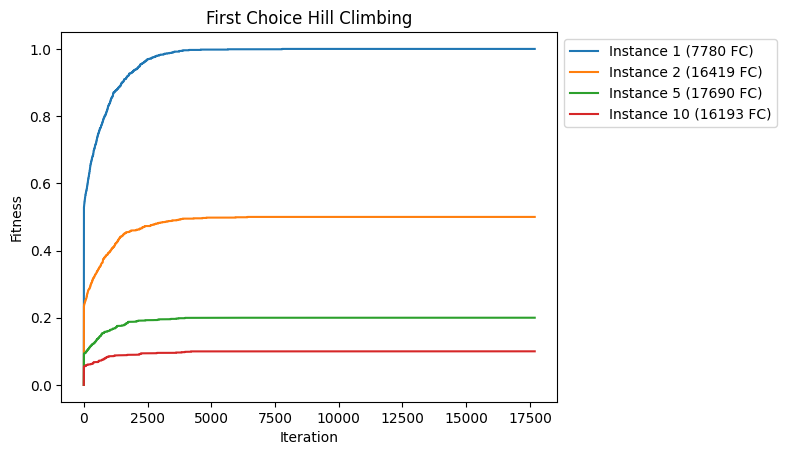

In [5]:
p_1 = lab9_lib.make_problem(1)
p_2 = lab9_lib.make_problem(2)
p_5 = lab9_lib.make_problem(5)
p_10 = lab9_lib.make_problem(10)


def neighbor(p:Individual, sample_size) -> Individual: 
    n = p.genome.copy()
    flip = sample(range(NUM_LOCI), sample_size)
    for f in flip:
        n[f] = 1 - n[f]
    return Individual(n)

def hill_climbing(fitness, distance=int(NUM_LOCI/2), max_wait=10000):
    current = Individual(choices([0, 1], k=NUM_LOCI))
    i = 0
    last_improvement = 0
    fitness_plot = [0]
    while current.evaluate(fitness)!=1 and i < last_improvement + max_wait:
        next = neighbor(current, distance)                              
        if next.evaluate(fitness) > current.evaluate(fitness):
            current = next
            last_improvement = i
        i += 1
        fitness_plot.append(current.evaluate(fitness))
    return fitness_plot, fitness.calls


hc1, hc1c = hill_climbing(p_1, 1)
hc2, hc2c = hill_climbing(p_2, 1)
hc5, hc5c = hill_climbing(p_5, 1)
hc10, hc10c = hill_climbing(p_10, 1)
x_axis = range(max(len(hc1), len(hc2), len(hc5), len(hc10)))
for a in [hc1, hc2, hc5, hc10]:
    while len(a) < len(x_axis):
        a.append(a[-1])

plt.title("First Choice Hill Climbing")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.plot(x_axis, hc1, label = "Instance 1 ("+str(hc1c)+" FC)")
plt.plot(x_axis, hc2, label = "Instance 2 ("+str(hc2c)+" FC)")
plt.plot(x_axis, hc5, label = "Instance 5 ("+str(hc5c)+" FC)")
plt.plot(x_axis, hc10, label = "Instance 10 ("+str(hc10c)+" FC)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

This approach requires a larger number of fitness calls but it seems to yield better results than the simple ES.

### Simulated Annealing
Let's try using Simulated Annealing, this algorithm tries to avoid local minima while trying to minimize a function by allowing "bad" moves with a probability that decreases at each iteration, we can turn it into a maximizing algorithm simply by changing the sign of the delta.

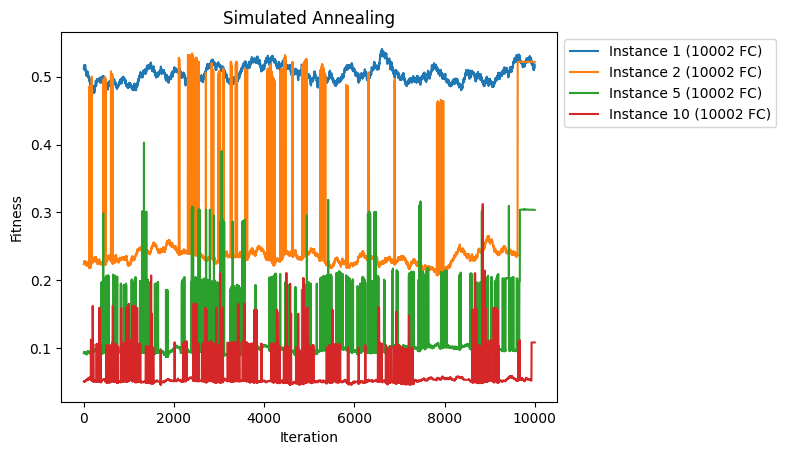

In [6]:
p_1 = lab9_lib.make_problem(1)
p_2 = lab9_lib.make_problem(2)
p_5 = lab9_lib.make_problem(5)
p_10 = lab9_lib.make_problem(10)




def simulated_annealing(fitness, distance=int(NUM_LOCI/2), T = 1 ,cooling=0.0001):
    current = Individual(choices([0, 1], k=NUM_LOCI))
    fitness_plot = [current.evaluate(fitness)]
    t = T
    while t > 0:
        next = neighbor(current, distance)
        delta = next.evaluate(fitness) - current.evaluate(fitness)
        if delta > 0:
            current = next
        elif random() < exp(delta/t):
            current = next
        fitness_plot.append(current.evaluate(fitness))
        t = t - cooling * T
    return fitness_plot, fitness.calls


sa1, sa1c = simulated_annealing(p_1, distance=1)
sa2, sa2c = simulated_annealing(p_2, distance=1)
sa5, sa5c = simulated_annealing(p_5, distance=1)
sa10, sa10c = simulated_annealing(p_10, distance=1)
x_axis = range(len(sa1))

plt.title("Simulated Annealing")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.plot(x_axis, sa1, label = "Instance 1 ("+str(sa1c)+" FC)")
plt.plot(x_axis, sa2, label = "Instance 2 ("+str(sa2c)+" FC)")
plt.plot(x_axis, sa5, label = "Instance 5 ("+str(sa5c)+" FC)")
plt.plot(x_axis, sa10, label = "Instance 10 ("+str(sa10c)+" FC)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()




Using this algorithm we can easily limit the amount of fitness calls by tweaking the cooling factor, for comparison purposes we set the cooling factor so that the number of FCs is around 10000.

### Comparisons
Let's compare the algorithms tried so far by using a scatter plot.

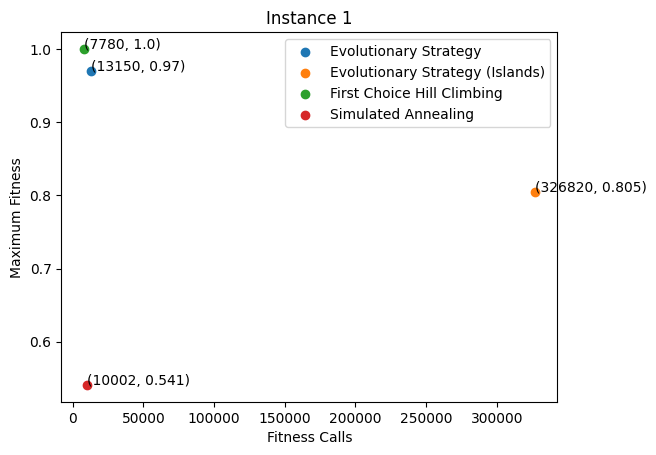

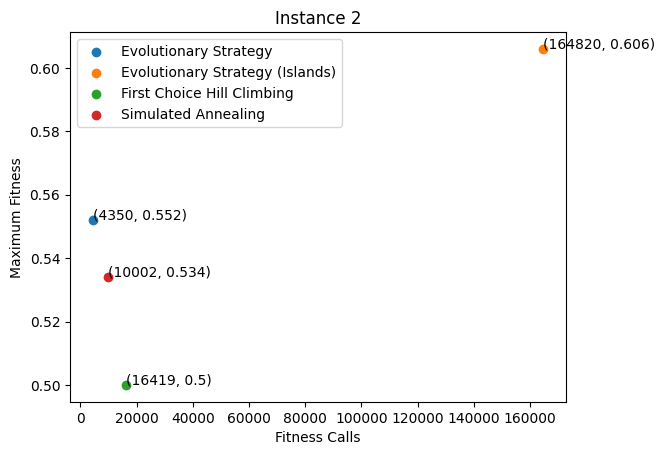

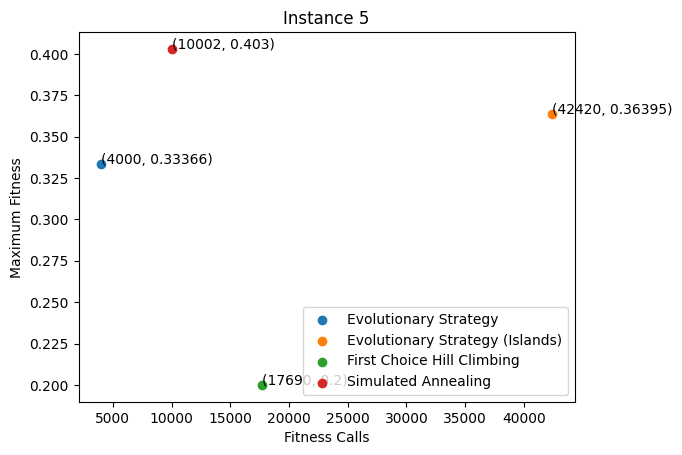

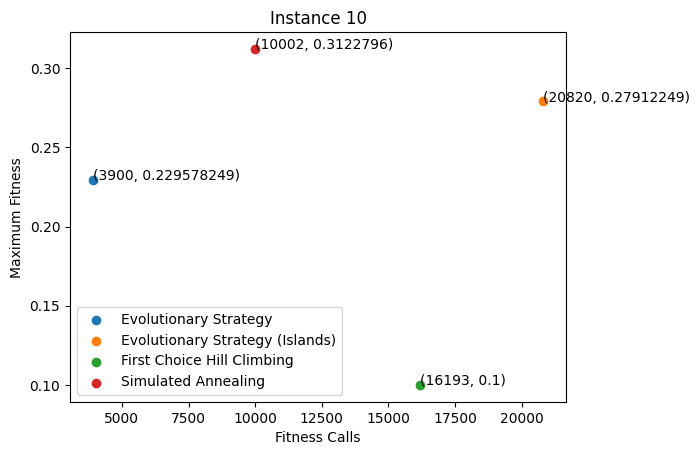

In [7]:
ess = [max(es1), max(es2), max(es5), max(es10)]
escs = [es1c, es2c, es5c, es10c]
esis = [max(esi1), max(esi2), max(esi5), max(esi10)]
esics = [esi1c, esi2c, esi5c, esi10c]
hcs = [max(hc1), max(hc2), max(hc5), max(hc10)]
hccs = [hc1c, hc2c, hc5c, hc10c]
sas = [max(sa1), max(sa2), max(sa5), max(sa10)]
sacs = [sa1c, sa2c, sa5c, sa10c]

titles = ["Instance 1", "Instance 2", "Instance 5", "Instance 10"]

for i in range(4):   
    plt.figure(i)
    plt.ylabel("Maximum Fitness")
    plt.xlabel("Fitness Calls")
    plt.scatter(escs[i], ess[i], label='Evolutionary Strategy')
    plt.text(escs[i], ess[i], '({}, {})'.format(escs[i], ess[i]))
    plt.scatter(esics[i], esis[i], label='Evolutionary Strategy (Islands)')
    plt.text(esics[i], esis[i], '({}, {})'.format(esics[i], esis[i]))
    plt.scatter(hccs[i], hcs[i], label='First Choice Hill Climbing')
    plt.text(hccs[i], hcs[i], '({}, {})'.format(hccs[i], hcs[i]))
    plt.scatter(sacs[i], sas[i], label='Simulated Annealing')
    plt.text(sacs[i], sas[i], '({}, {})'.format(sacs[i], sas[i]))
    plt.legend()
    plt.title(titles[i])
    plt.show()
    


### Conclusions
- The evolutionary strategies we defined seem to be able to find a good solution of the problem only for the easier instances at the cost of a much bigger amount of fitness calls. This could be likely improved by experimenting with a better crossover function or by increasing the selective pressure.
- The Hill Climbing algorithm is the best so far for the problem of instance 1, however as the problem becomes harder its performance lowers, perhaps performing neighbor discovery with a strategy that takes in consideration the difficulty of the problem could yield better results.
- Simulated Annealing is the algorithm that performs better for the harder instances of the problem.

## References
[Giovanni Squillero](https://github.com/squillero/computational-intelligence) for the original code<br>
[Artificial Intelligence: A Modern Approach 4th Edition by Russel, Norvig](https://www.google.it/books/edition/Artificial_Intelligence_A_Modern_Approac/cb0qEAAAQBAJ?hl=it) for some code ideas